In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
import xarray as xr 

from include.neural_net import NeuralNet

In [2]:
# Load the Covid data
Covid_data = pd.read_csv("../../data/Covid_lessdat/Berlin_data/data.csv", index_col=0)
Covid_data.index = pd.to_datetime(Covid_data.index)

In [3]:
Covid_data.columns

Index(['susceptible', 'exposed', 'infected', 'recovered', 'symptomatic',
       'hospitalized', 'critical', 'deceased', 'quarantine_S', 'quarantine_E',
       'quarantine_I', 'contact_traced'],
      dtype='object')

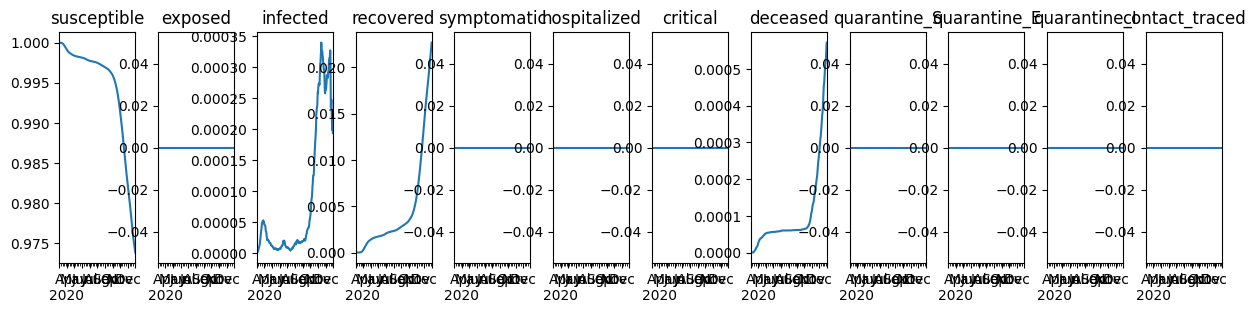

In [4]:
fig, axs = plt.subplots(ncols=12, figsize=(15, 3), gridspec_kw=dict(wspace=0.3))
for idx, col in enumerate(Covid_data.columns):
    Covid_data[col].plot(ax=axs[idx], title=col)

In [5]:
# Split into a training and test/prediction set
training_data, test_data = torch.from_numpy(Covid_data.values).float()[:286], torch.from_numpy(Covid_data.values).float()[286:]
alpha = training_data.sum(dim=0)**(-1)
training_data.shape, test_data.shape, alpha.shape

(torch.Size([286, 12]), torch.Size([17, 12]), torch.Size([12]))

In [6]:
# Define a simple SIR model
def SIR_model(state: torch.Tensor, parameters: dict) -> torch.Tensor:
    k_Q = 10.25 * parameters["k_CT"] * state[-1]
    new_state = state + torch.stack([(-parameters["k_E"] * state[2] - k_Q)
                                * state[0]
                                + parameters["k_S"] * state[8],

                                parameters["k_E"] * state[0] * state[2]
                                - (parameters["k_I"] + k_Q) * state[1],

                                parameters["k_I"] * state[1]
                                - (parameters["k_R"] + parameters["k_SY"] + k_Q)
                                * state[2],

                                parameters["k_R"]
                                * (
                                    state[2]
                                    + state[4]
                                    + state[5]
                                    + state[6]
                                    + state[10]
                                ),

                                parameters["k_SY"]
                                * (state[2] + state[10])
                                - (parameters["k_R"] + parameters["k_H"])
                                * state[4],

                                parameters["k_H"] * state[4]
                                - (parameters["k_R"] + parameters["k_C"])
                                * state[5],

                                parameters["k_C"] * state[5]
                                - (parameters["k_R"] + parameters["k_D"])
                                * state[6],

                                parameters["k_D"] * state[6],

                                -parameters["k_S"] * state[8]
                                + k_Q * state[0],

                                -parameters["k_I"] * state[9]
                                + k_Q * state[1],

                                parameters["k_I"] * state[9]
                                + k_Q * state[2]
                                - (parameters["k_SY"] + parameters["k_R"])
                                * state[10],

                                parameters["k_SY"] * state[2]
                                - 10.25
                                * torch.sum(state[0:3])
                                * state[-1]]) * parameters['dt']
    return new_state

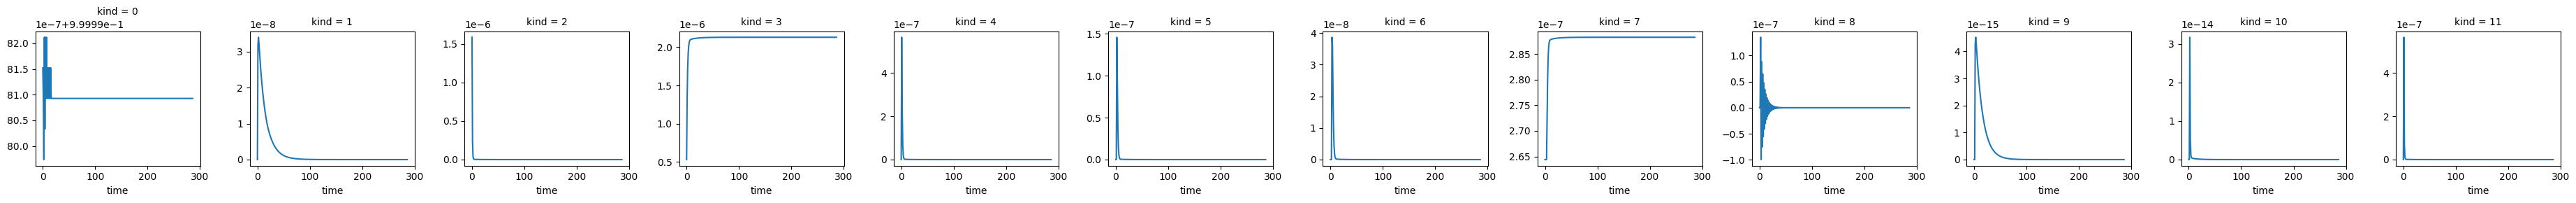

In [23]:
# Small example of the SIR model
t_change = [0, 10, 19, 64, 104, 182, 200, 242, 266, 286]
k_E_n = [0.1997, 0.2144, 0.9935, 1.5783, 2.1285, 1.2277, 1.5966, 2.9898, 2.9643, 2.6298]
data = [training_data[0]]# + torch.tensor([0, 0, 0.0001, 0, 0, 0, 0, 0, 0, 0, 0,0])
counter_change = 0
for n in range(training_data.shape[0]):
    if n == t_change[counter_change]:
        k_E_t = k_E_n[counter_change]
        counter_change += 1
    data.append(SIR_model(data[-1], parameters=dict(k_E=k_E_t,k_I= 0.7552, k_R= 4.9589, k_SY= 3.5624, k_H= 2.5788, k_C= 2.6510, k_D= 2.0733, k_CT= 0.2332, k_S= 18.5910, dt=0.1)))
xr.DataArray(data, dims=["time", "kind"]).plot(col="kind", sharey=False)

In [45]:
# Initialise the neural network
NN = NeuralNet(
    input_size=training_data.shape[1],
    output_size=18, #learn three parameters
    num_layers=5,
    nodes_per_layer=dict(default=20),
    activation_funcs=dict(default='sigmoid', layer_specific={0: 'softplus', -1: 'softplus'}),
    biases=dict(default=[-1, 1])
)

loss_ts = []

In [46]:
pred_param = []

In [47]:
parameter_order = ['k_I', 'k_R', 'k_D', 'k_CT', 'k_SY', 'k_H', 'k_C', 'k_S', 'k_E_0', 'k_E_1', 'k_E_2', 'k_E_3', 'k_E_4', 'k_E_5', 'k_E_6', 'k_E_7', 'k_E_8', 'k_E_9']

In [52]:
# Train
n_epochs = 200
batch_size = 20
write_every = 10
parameters = dict(dt=0.1)

for e in (pbar := tqdm.tqdm(range(n_epochs))):
    
    # Run the model, stopping to update the estimates every n steps
    predicted_data = [training_data[0].clone()]
    start_idx = 0
    epoch_loss = []
    _pred_param = []
    t_change = [0, 10, 19, 64, 104, 182, 200, 242, 266, 286]
    counter_change = 0
    
    for t in range(training_data.shape[0]):
        
        predicted_parameters = NN(training_data[t])
        predicted_parameters = torch.tensor([predicted_parameters[parameter_order.index(param)] for param in parameter_order])
        if e % write_every == 0:
            _pred_param.append(predicted_parameters.clone().detach())
        
        if t == t_change[counter_change]:
            k_E_t = predicted_parameters[counter_change+8]
            counter_change += 1
        
        predicted_data.append(SIR_model(predicted_data[-1], 
                                        parameters={'k_I': predicted_parameters[0], 'k_R': predicted_parameters[1], 'k_D': predicted_parameters[2],'k_CT': predicted_parameters[3], 'k_SY':predicted_parameters[4], 'k_H':predicted_parameters[5], 'k_C':predicted_parameters[6], 'k_S':predicted_parameters[7], 'k_E':k_E_t, 'dt': torch.tensor(0.1)}))

        if t > 0 and (len(predicted_data) % batch_size == 0):
            
            loss = (
                alpha * ((torch.stack(predicted_data)[1:, :] - training_data[start_idx+1:start_idx+len(predicted_data), :])**2).sum(dim=0)
            ).sum(dim=0)
            loss.backward()
            NN.optimizer.step()
            NN.optimizer.zero_grad()
            start_idx = t
            epoch_loss.append(loss.detach())
            if t < training_data.shape[0] - 1:
                predicted_data = [training_data[t+1].clone()]
    if e % write_every == 0:
        pred_param.append(_pred_param)
    loss_ts.append(np.mean(epoch_loss))
    pbar.set_description(f"Loss: {loss_ts[-1]}")

  0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

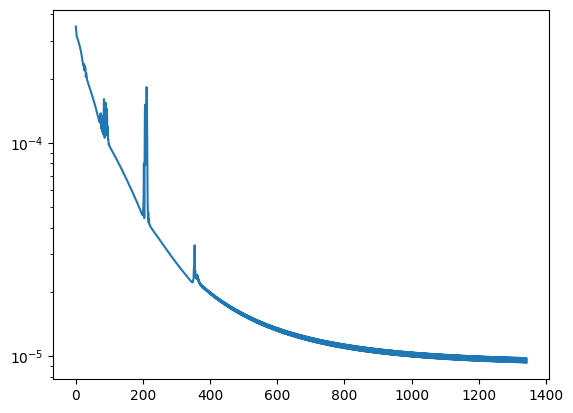

In [438]:
fig, ax = plt.subplots()
ax.plot(loss_ts)
ax.set_yscale('log')

In [439]:
preds = torch.stack([torch.stack(x) for x in pred_param])
preds.shape

torch.Size([135, 302, 3])

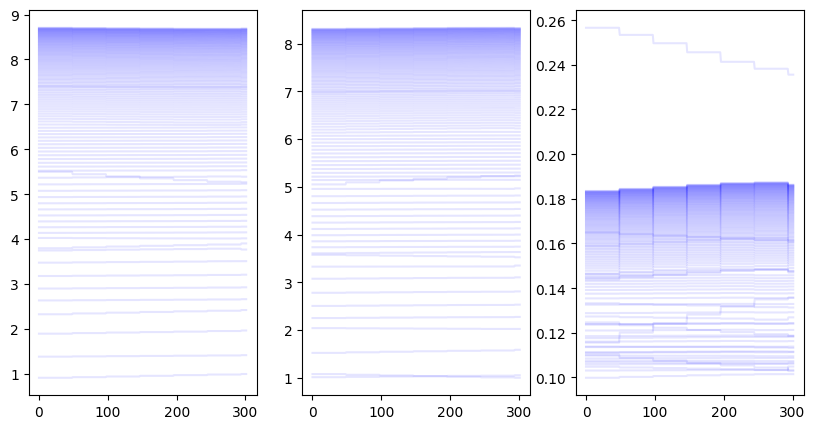

In [440]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 5))
for p in preds:
    for idx, arr in enumerate(p.transpose(0, 1)):
        axs[idx].plot(arr, alpha=0.1, color='blue')

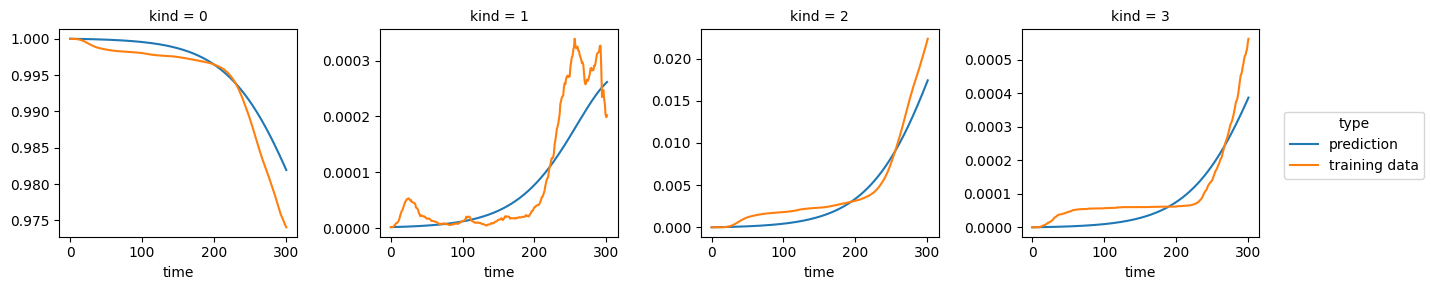

In [441]:
predicted_data = [training_data[0]]
for t in range(training_data.shape[0]):
    
    predicted_parameters = NN(training_data[t]).detach()
    predicted_data.append(SIR_model(predicted_data[t], 
                                    parameters={'k_I': predicted_parameters[0], 'k_R': predicted_parameters[1], 'k_D': predicted_parameters[2], 'dt': torch.tensor(0.1)}))
xr.concat([
    xr.DataArray(predicted_data[1:], dims=["time", "kind"]).expand_dims({'type': ['prediction']}), 
    xr.DataArray(training_data, dims=["time", "kind"]).expand_dims({'type': ['training data']})], dim='type').plot(col="kind", hue='type', sharey=False)